# Aggregate Accuracy

    The idea here to actually sum up the softmax scores for several frames for a single class rather than sinply use a single  frame. The hope is that there are several similarities between frames so what you would have is for a another class that  scores closely you would expect a chance that its intermediate frame discounts its aggregate score compared to the actual class. This would lead to a higher than expect aggregate score 

In [1]:
import os
import sys


up1 = os.path.abspath('../utils/') 
up2 = os.path.abspath('../models/') 
sys.path.insert(0, up1)
sys.path.insert(0, up2)

In [2]:


from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import keras
import cv2

import os, os.path
import random


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [9]:
# first create a  data generator that simply gets all 

class DataGenerator(keras.utils.Sequence):
    'Generate UCF 101 data for keras'
    def __init__(self, list_IDs, labels, data_dir, num_frames=10, num_rand_transforms=10, dim=(224,224), \
                 n_channels=3, n_classes=101):        
        'Initialisation'
        self.data_dir = data_dir
        self.dim = dim
        self.num_frames = num_frames
        self.num_rand_transforms = num_rand_transforms
        self.labels = labels
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        
        self.data_gen = ImageDataGenerator(rescale=1./255, \
                                          samplewise_center=True, samplewise_std_normalization=True)
        
        self.on_epoch_end()
    
    def  __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.list_IDs)
    
    def __getitem__(self, index):
        'Generate one batch of data'
        print(index)
        # find list of ids
        ID = self.list_IDs[index]
        
        # Generate data 
        X, y = self.__data_generation(ID)
        
        return X, y
    
    def __data_generation(self, ID):
        'Generates data containing batch_size samples' 
        X = np.empty((self.num_rand_transforms * self.num_frames, *self.dim,self.n_channels), dtype=np.float32)
        y = np.empty((self.num_rand_transforms * self.num_frames), dtype=int)
        
        # Generate data 
        _X = self.__data_load(ID)            
        y[:] = self.labels[ID]-1
            
        for i, img, in enumerate(_X):
            _X[i] = self.data_gen.standardize(_X[i])
        
        # for each frame apply the requisite number of random transformations
        k = 0
        for i in range(self.num_frames):
            for j in range(self.num_rand_transforms):
                X[k,] = self.data_gen.random_transform(_X[i])
                k = k + 1
        
        return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
    
    def __data_load(self, ID):
        file_dir = self.data_dir + "/jpegs_256/" + ID.rstrip('.avi')
        n_frames = len([name for name in os.listdir(file_dir) if os.path.isfile(file_dir + os.sep + name)])
        frame_range = range(1,n_frames+1,1)
        
        # select num_frames random frames
        frames = random.sample(frame_range, self.num_frames)
        # select random frame 
        images = list()
        for frame in frames:
            file = file_dir + '/frame' + f'{frame:06}' + '.jpg'
            img = cv2.imread(file)
            img = cv2.resize(img, self.dim) 
            img = cv2.normalize(img, dst=None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            images.append(img)
        return images
    

In [10]:
from ucf101_data_utils import get_test_data, get_train_data
from spatial_network import getVggModel, getResNet50Model, getVggModel2
from keras.optimizers import SGD
from matplotlib import pyplot as plt

In [11]:
id_labels_test = get_test_data('../data/ucf101_splits/testlist01.txt',
                              '../data/ucf101_splits/classInd.txt')

In [34]:
# Parameters
params = { 'data_dir' : "/data",
          'dim': (224,224),
          'num_frames': 10,
          'num_rand_transforms': 15,
          'n_channels': 3}

In [35]:
validation_generator = DataGenerator(*id_labels_test, **params)

In [37]:
X = None
y = None

i = 0

for (_x, _y) in validation_generator:
    X = _x
    y = _y
    if i == 1:        
        break
    i =  i + 1
len(validation_generator)

0
1


3783

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


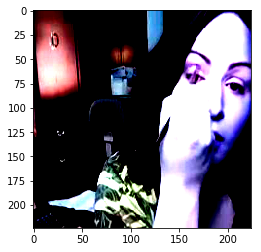

In [38]:
plt.imshow(X[0,:,:,:])

In [39]:
y[0].argmax(axis=0)

0

# Now to calculate soft max scores


In [40]:
model=getVggModel((224,224,3), printmod=0)

In [41]:
model.load_weights('../data/weights/spatial_model_weights_epoch51.hdf5')

In [42]:
X[0].shape

(224, 224, 3)

In [43]:
result = model.predict(X)

In [31]:
result

array([[9.0336250e-03, 3.2466756e-05, 9.6296519e-03, ..., 9.3648159e-05,
        2.5733371e-04, 9.9531724e-04],
       [9.0336250e-03, 3.2466756e-05, 9.6296519e-03, ..., 9.3648159e-05,
        2.5733371e-04, 9.9531724e-04],
       [9.0336250e-03, 3.2466756e-05, 9.6296519e-03, ..., 9.3648159e-05,
        2.5733371e-04, 9.9531724e-04],
       ...,
       [8.7507786e-03, 5.4462336e-05, 1.1792637e-02, ..., 2.0550920e-05,
        5.3061729e-05, 2.5677396e-04],
       [8.7507786e-03, 5.4462336e-05, 1.1792637e-02, ..., 2.0550920e-05,
        5.3061729e-05, 2.5677396e-04],
       [8.7507786e-03, 5.4462336e-05, 1.1792637e-02, ..., 2.0550920e-05,
        5.3061729e-05, 2.5677396e-04]], dtype=float32)

In [44]:
result_avg = np.average(result, axis=0)

In [47]:
#result_avg.shape
result_avg.argmax(axis=0)

33

In [19]:
result[:,0]

array([0.9103543 , 0.9103543 , 0.9103543 , 0.9103543 , 0.7302189 ,
       0.7302189 , 0.7302189 , 0.7302189 , 0.45928127, 0.45928127,
       0.45928127, 0.45928127, 0.9342837 , 0.9342837 , 0.9342837 ,
       0.9342837 , 0.7494607 , 0.7494607 , 0.7494607 , 0.7494607 ,
       0.971123  , 0.971123  , 0.971123  , 0.971123  , 0.7570883 ,
       0.7570883 , 0.7570883 , 0.7570883 , 0.9018647 , 0.9018647 ,
       0.9018647 , 0.9018647 ], dtype=float32)

In [20]:
y[0,:]


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [21]:
i = 0
for (X, y) in validation_generator:
    result = model.predict(X)
    f1 = open('/data/temp/inference_result/result' + str(i) + '.npy' , 'wb')
    f2 = open('/data/temp/inference_result/result_class' + str(i) + '.npy' , 'wb')
    np.save(f1, result)
    print('y_argmax',  y[0].argmax(axis=0))
    np.save(f2, y)    
    i = i + 1

0
y_argmax 0
1
y_argmax 0
2
y_argmax 0
3
y_argmax 0
4
y_argmax 0
5
y_argmax 0
6
y_argmax 0
7
y_argmax 0
8
y_argmax 0
9
y_argmax 0
10
y_argmax 0
11
y_argmax 0
12
y_argmax 0
13
y_argmax 0
14
y_argmax 0
15
y_argmax 0
16
y_argmax 0
17
y_argmax 0
18
y_argmax 0
19
y_argmax 0
20
y_argmax 0
21
y_argmax 0
22
y_argmax 0
23
y_argmax 0
24
y_argmax 0
25
y_argmax 0
26
y_argmax 0
27
y_argmax 0
28
y_argmax 0
29
y_argmax 0
30
y_argmax 0
31
y_argmax 0
32
y_argmax 0
33
y_argmax 0
34
y_argmax 0
35
y_argmax 0
36
y_argmax 0
37
y_argmax 0
38
y_argmax 0
39
y_argmax 0
40
y_argmax 0
41
y_argmax 0
42
y_argmax 0
43
y_argmax 0
44
y_argmax 1
45
y_argmax 1
46
y_argmax 1
47
y_argmax 1
48
y_argmax 1
49
y_argmax 1
50
y_argmax 1
51
y_argmax 1
52
y_argmax 1
53
y_argmax 1
54
y_argmax 1
55
y_argmax 1
56
y_argmax 1
57
y_argmax 1
58
y_argmax 1
59
y_argmax 1
60
y_argmax 1
61
y_argmax 1
62
y_argmax 1
63
y_argmax 1
64
y_argmax 1
65
y_argmax 1
66
y_argmax 1
67
y_argmax 1
68
y_argmax 1
69
y_argmax 1
70
y_argmax 1
71
y_argmax 1
72

y_argmax 14
544
y_argmax 14
545
y_argmax 14
546
y_argmax 14
547
y_argmax 14
548
y_argmax 14
549
y_argmax 14
550
y_argmax 14
551
y_argmax 14
552
y_argmax 14
553
y_argmax 14
554
y_argmax 14
555
y_argmax 14
556
y_argmax 14
557
y_argmax 14
558
y_argmax 14
559
y_argmax 14
560
y_argmax 14
561
y_argmax 14
562
y_argmax 14
563
y_argmax 14
564
y_argmax 14
565
y_argmax 14
566
y_argmax 14
567
y_argmax 14
568
y_argmax 15
569
y_argmax 15
570
y_argmax 15
571
y_argmax 15
572
y_argmax 15
573
y_argmax 15
574
y_argmax 15
575
y_argmax 15
576
y_argmax 15
577
y_argmax 15
578
y_argmax 15
579
y_argmax 15
580
y_argmax 15
581
y_argmax 15
582
y_argmax 15
583
y_argmax 15
584
y_argmax 15
585
y_argmax 15
586
y_argmax 15
587
y_argmax 15
588
y_argmax 15
589
y_argmax 15
590
y_argmax 15
591
y_argmax 15
592
y_argmax 15
593
y_argmax 15
594
y_argmax 15
595
y_argmax 15
596
y_argmax 15
597
y_argmax 15
598
y_argmax 15
599
y_argmax 15
600
y_argmax 15
601
y_argmax 15
602
y_argmax 15
603
y_argmax 15
604
y_argmax 15
605
y_argmax

y_argmax 27
1053
y_argmax 27
1054
y_argmax 27
1055
y_argmax 27
1056
y_argmax 27
1057
y_argmax 27
1058
y_argmax 27
1059
y_argmax 27
1060
y_argmax 27
1061
y_argmax 27
1062
y_argmax 27
1063
y_argmax 27
1064
y_argmax 27
1065
y_argmax 27
1066
y_argmax 27
1067
y_argmax 27
1068
y_argmax 27
1069
y_argmax 27
1070
y_argmax 27
1071
y_argmax 27
1072
y_argmax 27
1073
y_argmax 27
1074
y_argmax 27
1075
y_argmax 28
1076
y_argmax 28
1077
y_argmax 28
1078
y_argmax 28
1079
y_argmax 28
1080
y_argmax 28
1081
y_argmax 28
1082
y_argmax 28
1083
y_argmax 28
1084
y_argmax 28
1085
y_argmax 28
1086
y_argmax 28
1087
y_argmax 28
1088
y_argmax 28
1089
y_argmax 28
1090
y_argmax 28
1091
y_argmax 28
1092
y_argmax 28
1093
y_argmax 28
1094
y_argmax 28
1095
y_argmax 28
1096
y_argmax 28
1097
y_argmax 28
1098
y_argmax 28
1099
y_argmax 28
1100
y_argmax 28
1101
y_argmax 28
1102
y_argmax 28
1103
y_argmax 28
1104
y_argmax 28
1105
y_argmax 28
1106
y_argmax 28
1107
y_argmax 28
1108
y_argmax 28
1109
y_argmax 28
1110
y_argmax 28
11

y_argmax 40
1535
y_argmax 40
1536
y_argmax 40
1537
y_argmax 40
1538
y_argmax 40
1539
y_argmax 40
1540
y_argmax 40
1541
y_argmax 40
1542
y_argmax 40
1543
y_argmax 40
1544
y_argmax 40
1545
y_argmax 40
1546
y_argmax 40
1547
y_argmax 40
1548
y_argmax 40
1549
y_argmax 40
1550
y_argmax 41
1551
y_argmax 41
1552
y_argmax 41
1553
y_argmax 41
1554
y_argmax 41
1555
y_argmax 41
1556
y_argmax 41
1557
y_argmax 41
1558
y_argmax 41
1559
y_argmax 41
1560
y_argmax 41
1561
y_argmax 41
1562
y_argmax 41
1563
y_argmax 41
1564
y_argmax 41
1565
y_argmax 41
1566
y_argmax 41
1567
y_argmax 41
1568
y_argmax 41
1569
y_argmax 41
1570
y_argmax 41
1571
y_argmax 41
1572
y_argmax 41
1573
y_argmax 41
1574
y_argmax 41
1575
y_argmax 41
1576
y_argmax 41
1577
y_argmax 41
1578
y_argmax 41
1579
y_argmax 41
1580
y_argmax 41
1581
y_argmax 41
1582
y_argmax 41
1583
y_argmax 41
1584
y_argmax 41
1585
y_argmax 41
1586
y_argmax 41
1587
y_argmax 41
1588
y_argmax 41
1589
y_argmax 41
1590
y_argmax 41
1591
y_argmax 41
1592
y_argmax 41
15

y_argmax 53
2017
y_argmax 53
2018
y_argmax 53
2019
y_argmax 53
2020
y_argmax 53
2021
y_argmax 53
2022
y_argmax 53
2023
y_argmax 53
2024
y_argmax 53
2025
y_argmax 53
2026
y_argmax 53
2027
y_argmax 53
2028
y_argmax 53
2029
y_argmax 53
2030
y_argmax 53
2031
y_argmax 53
2032
y_argmax 53
2033
y_argmax 53
2034
y_argmax 53
2035
y_argmax 53
2036
y_argmax 53
2037
y_argmax 53
2038
y_argmax 53
2039
y_argmax 53
2040
y_argmax 53
2041
y_argmax 53
2042
y_argmax 53
2043
y_argmax 53
2044
y_argmax 53
2045
y_argmax 53
2046
y_argmax 53
2047
y_argmax 53
2048
y_argmax 53
2049
y_argmax 54
2050
y_argmax 54
2051
y_argmax 54
2052
y_argmax 54
2053
y_argmax 54
2054
y_argmax 54
2055
y_argmax 54
2056
y_argmax 54
2057
y_argmax 54
2058
y_argmax 54
2059
y_argmax 54
2060
y_argmax 54
2061
y_argmax 54
2062
y_argmax 54
2063
y_argmax 54
2064
y_argmax 54
2065
y_argmax 54
2066
y_argmax 54
2067
y_argmax 54
2068
y_argmax 54
2069
y_argmax 54
2070
y_argmax 54
2071
y_argmax 54
2072
y_argmax 54
2073
y_argmax 54
2074
y_argmax 54
20

y_argmax 65
2499
y_argmax 65
2500
y_argmax 65
2501
y_argmax 65
2502
y_argmax 65
2503
y_argmax 65
2504
y_argmax 65
2505
y_argmax 65
2506
y_argmax 65
2507
y_argmax 65
2508
y_argmax 65
2509
y_argmax 65
2510
y_argmax 65
2511
y_argmax 65
2512
y_argmax 65
2513
y_argmax 65
2514
y_argmax 65
2515
y_argmax 65
2516
y_argmax 66
2517
y_argmax 66
2518
y_argmax 66
2519
y_argmax 66
2520
y_argmax 66
2521
y_argmax 66
2522
y_argmax 66
2523
y_argmax 66
2524
y_argmax 66
2525
y_argmax 66
2526
y_argmax 66
2527
y_argmax 66
2528
y_argmax 66
2529
y_argmax 66
2530
y_argmax 66
2531
y_argmax 66
2532
y_argmax 66
2533
y_argmax 66
2534
y_argmax 66
2535
y_argmax 66
2536
y_argmax 66
2537
y_argmax 66
2538
y_argmax 66
2539
y_argmax 66
2540
y_argmax 66
2541
y_argmax 66
2542
y_argmax 66
2543
y_argmax 66
2544
y_argmax 67
2545
y_argmax 67
2546
y_argmax 67
2547
y_argmax 67
2548
y_argmax 67
2549
y_argmax 67
2550
y_argmax 67
2551
y_argmax 67
2552
y_argmax 67
2553
y_argmax 67
2554
y_argmax 67
2555
y_argmax 67
2556
y_argmax 67
25

y_argmax 78
2981
y_argmax 78
2982
y_argmax 78
2983
y_argmax 78
2984
y_argmax 78
2985
y_argmax 78
2986
y_argmax 78
2987
y_argmax 79
2988
y_argmax 79
2989
y_argmax 79
2990
y_argmax 79
2991
y_argmax 79
2992
y_argmax 79
2993
y_argmax 79
2994
y_argmax 79
2995
y_argmax 79
2996
y_argmax 79
2997
y_argmax 79
2998
y_argmax 79
2999
y_argmax 79
3000
y_argmax 79
3001
y_argmax 79
3002
y_argmax 79
3003
y_argmax 79
3004
y_argmax 79
3005
y_argmax 79
3006
y_argmax 79
3007
y_argmax 79
3008
y_argmax 79
3009
y_argmax 79
3010
y_argmax 79
3011
y_argmax 79
3012
y_argmax 79
3013
y_argmax 79
3014
y_argmax 79
3015
y_argmax 79
3016
y_argmax 79
3017
y_argmax 79
3018
y_argmax 79
3019
y_argmax 80
3020
y_argmax 80
3021
y_argmax 80
3022
y_argmax 80
3023
y_argmax 80
3024
y_argmax 80
3025
y_argmax 80
3026
y_argmax 80
3027
y_argmax 80
3028
y_argmax 80
3029
y_argmax 80
3030
y_argmax 80
3031
y_argmax 80
3032
y_argmax 80
3033
y_argmax 80
3034
y_argmax 80
3035
y_argmax 80
3036
y_argmax 80
3037
y_argmax 80
3038
y_argmax 80
30

y_argmax 92
3463
y_argmax 92
3464
y_argmax 92
3465
y_argmax 92
3466
y_argmax 92
3467
y_argmax 92
3468
y_argmax 92
3469
y_argmax 92
3470
y_argmax 92
3471
y_argmax 92
3472
y_argmax 92
3473
y_argmax 92
3474
y_argmax 92
3475
y_argmax 92
3476
y_argmax 92
3477
y_argmax 92
3478
y_argmax 92
3479
y_argmax 92
3480
y_argmax 92
3481
y_argmax 92
3482
y_argmax 92
3483
y_argmax 92
3484
y_argmax 92
3485
y_argmax 92
3486
y_argmax 92
3487
y_argmax 92
3488
y_argmax 92
3489
y_argmax 92
3490
y_argmax 92
3491
y_argmax 92
3492
y_argmax 92
3493
y_argmax 93
3494
y_argmax 93
3495
y_argmax 93
3496
y_argmax 93
3497
y_argmax 93
3498
y_argmax 93
3499
y_argmax 93
3500
y_argmax 93
3501
y_argmax 93
3502
y_argmax 93
3503
y_argmax 93
3504
y_argmax 93
3505
y_argmax 93
3506
y_argmax 93
3507
y_argmax 93
3508
y_argmax 93
3509
y_argmax 93
3510
y_argmax 93
3511
y_argmax 93
3512
y_argmax 93
3513
y_argmax 93
3514
y_argmax 93
3515
y_argmax 93
3516
y_argmax 93
3517
y_argmax 93
3518
y_argmax 93
3519
y_argmax 93
3520
y_argmax 93
35

y_argmax 5
189
y_argmax 5
190
y_argmax 5
191
y_argmax 5
192
y_argmax 5
193
y_argmax 5
194
y_argmax 5
195
y_argmax 5
196
y_argmax 5
197
y_argmax 5
198
y_argmax 5
199
y_argmax 5
200
y_argmax 5
201
y_argmax 5
202
y_argmax 5
203
y_argmax 5
204
y_argmax 5
205
y_argmax 5
206
y_argmax 5
207
y_argmax 5
208
y_argmax 5
209
y_argmax 5
210
y_argmax 5
211
y_argmax 5
212
y_argmax 5
213
y_argmax 5
214
y_argmax 5
215
y_argmax 5
216
y_argmax 5
217
y_argmax 5
218
y_argmax 5
219
y_argmax 5
220
y_argmax 5
221
y_argmax 5
222
y_argmax 5
223
y_argmax 5
224
y_argmax 5
225
y_argmax 5
226
y_argmax 6
227
y_argmax 6
228
y_argmax 6
229
y_argmax 6
230
y_argmax 6
231
y_argmax 6
232
y_argmax 6
233
y_argmax 6
234
y_argmax 6
235
y_argmax 6
236
y_argmax 6
237
y_argmax 6
238
y_argmax 6
239
y_argmax 6
240
y_argmax 6
241
y_argmax 6
242
y_argmax 6
243
y_argmax 6
244
y_argmax 6
245
y_argmax 6
246
y_argmax 6
247
y_argmax 6
248
y_argmax 6
249
y_argmax 6
250
y_argmax 6
251
y_argmax 6
252
y_argmax 6
253
y_argmax 6
254
y_argmax 6

y_argmax 18
714
y_argmax 18
715
y_argmax 18
716
y_argmax 18
717
y_argmax 18
718
y_argmax 18
719
y_argmax 18
720
y_argmax 18
721
y_argmax 18
722
y_argmax 18
723
y_argmax 18
724
y_argmax 18
725
y_argmax 19
726
y_argmax 19
727
y_argmax 19
728
y_argmax 19
729
y_argmax 19
730
y_argmax 19
731
y_argmax 19
732
y_argmax 19
733
y_argmax 19
734
y_argmax 19
735
y_argmax 19
736
y_argmax 19
737
y_argmax 19
738
y_argmax 19
739
y_argmax 19
740
y_argmax 19
741
y_argmax 19
742
y_argmax 19
743
y_argmax 19
744
y_argmax 19
745
y_argmax 19
746
y_argmax 19
747
y_argmax 19
748
y_argmax 19
749
y_argmax 19
750
y_argmax 19
751
y_argmax 19
752
y_argmax 19
753
y_argmax 19
754
y_argmax 19
755
y_argmax 19
756
y_argmax 19
757
y_argmax 19
758
y_argmax 19
759
y_argmax 19
760
y_argmax 19
761
y_argmax 20
762
y_argmax 20
763
y_argmax 20
764
y_argmax 20
765
y_argmax 20
766
y_argmax 20
767
y_argmax 20
768
y_argmax 20
769
y_argmax 20
770
y_argmax 20
771
y_argmax 20
772
y_argmax 20
773
y_argmax 20
774
y_argmax 20
775
y_argmax

y_argmax 31
1213
y_argmax 31
1214
y_argmax 31
1215
y_argmax 31
1216
y_argmax 31
1217
y_argmax 31
1218
y_argmax 31
1219
y_argmax 31
1220
y_argmax 31
1221
y_argmax 31
1222
y_argmax 31
1223
y_argmax 31
1224
y_argmax 31
1225
y_argmax 32
1226
y_argmax 32
1227
y_argmax 32
1228
y_argmax 32
1229
y_argmax 32
1230
y_argmax 32
1231
y_argmax 32
1232
y_argmax 32
1233
y_argmax 32
1234
y_argmax 32
1235
y_argmax 32
1236
y_argmax 32
1237
y_argmax 32
1238
y_argmax 32
1239
y_argmax 32
1240
y_argmax 32
1241
y_argmax 32
1242
y_argmax 32
1243
y_argmax 32
1244
y_argmax 32
1245
y_argmax 32
1246
y_argmax 32
1247
y_argmax 32
1248
y_argmax 32
1249
y_argmax 32
1250
y_argmax 32
1251
y_argmax 32
1252
y_argmax 32
1253
y_argmax 32
1254
y_argmax 32
1255
y_argmax 32
1256
y_argmax 32
1257
y_argmax 32
1258
y_argmax 32
1259
y_argmax 32
1260
y_argmax 32
1261
y_argmax 32
1262
y_argmax 32
1263
y_argmax 32
1264
y_argmax 33
1265
y_argmax 33
1266
y_argmax 33
1267
y_argmax 33
1268
y_argmax 33
1269
y_argmax 33
1270
y_argmax 33
12

KeyboardInterrupt: 

## Now  we'll process the data

In [49]:
f = open('/data/temp/inference_result/result0.npy', 'rb')
d = np.load(f)

In [50]:
d[0,33]

0.28940332

In [51]:
d[0].argmax(axis=0
           )

33

In [58]:
y_pred = np.zeros((3783), dtype=int)
y_actual = np.zeros((3783), dtype=int)

In [64]:
inference_dir = '/data/temp/inference_result/'
inference_files = [name for name in os.listdir(inference_dir) if not name.startswith('result_class')]
prediction_actual_files = [name for name in os.listdir(inference_dir) if name.startswith('result_class')]

In [65]:
import  re
inference_files_sorted = sorted(inference_files, key=lambda x: int(re.sub('\D', '', x)))

inference_files_sorted = inference_files_sorted[0:3782]

prediction_actual_files_sorted = sorted(prediction_actual_files, key=lambda x: int(re.sub('\D', '', x)))

prediction_actual_files_sorted = prediction_actual_files_sorted[0:3782]

In [66]:
i = 0
for inference_file in inference_files_sorted:
    file = inference_dir + inference_file
    f = open(file, 'rb')
    inference = np.load(f)
    f.close()
    inference_avg = np.average(inference, axis=0)
    y_pred[i] = inference_avg.argmax(axis=0)
    i = i + 1

In [67]:
y_pred[0:33]

array([33, 33,  0,  0,  0,  0,  0,  0,  0, 12, 19, 19,  1,  1,  0, 19,  0,
        0, 61,  0,  0,  0,  0,  0,  0,  0,  0, 33,  0,  0,  1,  1, 19])

In [68]:
i = 0
for pred_actual_file in prediction_actual_files_sorted:
    file = inference_dir + pred_actual_file
    f = open(file, 'rb')
    pred_actual = np.load(f)
    f.close()    
    y_actual[i] = pred_actual[0].argmax(axis=0)
    i = i + 1

In [69]:
y_actual[0:33]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [71]:
result = y_actual == y_pred

In [74]:
np.sum(result.astype(int))/len(result)

0.6582077716098335

In [49]:
inference_files_sorted

['result0.npy',
 'result1.npy',
 'result2.npy',
 'result3.npy',
 'result4.npy',
 'result5.npy',
 'result6.npy',
 'result7.npy',
 'result8.npy',
 'result9.npy',
 'result10.npy',
 'result11.npy',
 'result12.npy',
 'result13.npy',
 'result14.npy',
 'result15.npy',
 'result16.npy',
 'result17.npy',
 'result18.npy',
 'result19.npy',
 'result20.npy',
 'result21.npy',
 'result22.npy',
 'result23.npy',
 'result24.npy',
 'result25.npy',
 'result26.npy',
 'result27.npy',
 'result28.npy',
 'result29.npy',
 'result30.npy',
 'result31.npy',
 'result32.npy',
 'result33.npy',
 'result34.npy',
 'result35.npy',
 'result36.npy',
 'result37.npy',
 'result38.npy',
 'result39.npy',
 'result40.npy',
 'result41.npy',
 'result42.npy',
 'result43.npy',
 'result44.npy',
 'result45.npy',
 'result46.npy',
 'result47.npy',
 'result48.npy',
 'result49.npy',
 'result50.npy',
 'result51.npy',
 'result52.npy',
 'result53.npy',
 'result54.npy',
 'result55.npy',
 'result56.npy',
 'result57.npy',
 'result58.npy',
 'resul